# Summary

Some papers claim that it is possible to time the market using seasonality on SP500. One justification is that people tend to get paid on Fridays and at the end of the month and this is when they invest and increase stocks demand.

If true, this can be particularly interesting if you believe in naive investing and you invest a fixed amount every month on diversified ETFs. Knowing when to invest during the month could in theory slightly increase your returns over time. 50% of my portfolio follows a naive investment approach where I invest a fix amount on the very diversified "Vanguard All World" which has a portfolio of approximately 3,900 holdings in nearly 50 countries. The analysis started on the May 24th, 2012, the ETF creation day and finishes the April 1st, 2020. There are 1988 days

I encourage running this analysis on your favourite investments before taking any conclusions because results can be very different. It is important to include the dividends in the analysis as this can completely change the results.

With regards to day of week seasonality, Wednesday is the day with the highest median return and the day with the smaller return variance. Friday is on the other hand the weakest day in terms of median performance. Using a Kolmogorov Smirnov test, we see that the p-value between the distributions of those 2 days is 0.10. This means that the difference is statistically significant and we can conclude outperformance on Wednesday in comparison to Friday
On day of month we can see outperformance on the 1st and 16th of the month which could be explained by automatic payments.

When splitting the days of months in two groups ( the first group contains all days from the 1st to the 16th and the second group the rest), we see an outperformance of the first group while returns of both groups are positive. With a higher median for the first group and with a p-value of 0.24, we can conclude with 76% confidence that there is a benefit to be invested the first part of the month.


**this notebook contains:**
* how to load financial data from investing.com
* how to add dividend returns on ex-date
* how to create seasonality features
* analyse density plot with seaborn
* estimate statistical significance with a Kolmogorov-Smirnov test

# Set environment

In [1]:
import pandas as pd
import investpy
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import ks_2samp
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# Get data

The dividend data has been manually downloaded from the Vanguard website and saved as csv on my github repo. If you analyse another ETF you will need to update the sheet.

Dealing with dividend is very important as it completely changes the results of the analysis

In [2]:
# historical data
df = investpy.etfs.get_etf_historical_data('Vanguard FTSE All-World UCITS USD Inc', country='united kingdom'
                                      , from_date ='01/01/2012', to_date ='01/04/2020')
df.head(2)
# dividend data
div_url = 'https://raw.githubusercontent.com/charlesdethibault/my-library/master/datasets/VWRL_div.csv'
div = pd.read_csv(div_url)
div.head(2)

print('the time-series consists of '+str(len(df))+' days')

,Open,High,Low,Close,Currency,Exchange
Date,,,,,,
2012-05-24,49.77,49.77,49.77,49.77,USD,London
2012-05-25,49.63,49.63,49.63,49.63,USD,London


,Distribution rate (per unit),Ex-dividend date,Record date,Payable date
0,0.11,2012-06-27,2012-06-29,2012-07-06
1,0.26,2012-09-26,2012-09-28,2012-10-05


the time-series consists of 1988 days


# Compute daily returns and add dividend return on ex-date

In [3]:
#create a new columns price close shift by one day
df['last_close']= df['Close'].shift(1)
# rename dividend columns
div.columns = ['div_USD','ex','record','pay'] 
# set ex date as index date
div = div.set_index('ex')
# merge historical data with dividend data
div = pd.merge(div, df, how='left',left_index=True, right_index=True)
# compute daily returns of ex dividend date
div['pct_change'] = (div['Close']+div['div_USD'])/div['last_close']-1 
# compute daily returns on non ex-dates
df['pct_change'] = df.Close.pct_change()
# remove useless column
div = div[['pct_change']]
df = df[['pct_change']]
# drop first row
df.dropna(subset = ["pct_change"], inplace=True)
# update the historical data with the df
print('\033[1m'+'before changes on the 2012-09-26 ex-date:'+'\033[0m')
df.loc['2012-09-25']
df.loc['2012-09-26']
df.update(div)
print('\033[1m'+'before changes on the 2012-09-26 ex-date:'+'\033[0m')
df.loc['2012-09-25']
df.loc['2012-09-26']
df['pct_change'] = df['pct_change']*100

before changes on the 2012-09-26 ex-date:


pct_change    0.006095
Name: 2012-09-25 00:00:00, dtype: float64

pct_change   -0.024768
Name: 2012-09-26 00:00:00, dtype: float64

before changes on the 2012-09-26 ex-date:


pct_change    0.006095
Name: 2012-09-25 00:00:00, dtype: float64

pct_change   -0.020135
Name: 2012-09-26 00:00:00, dtype: float64

In [4]:
df['date'] = df.index # index date as date column
df['weekday'] = df['date'].dt.day_name() # find day name
df['weekday_d'] = df['date'].dt.weekday 
df['dom'] = df['date'].dt.day # day of month
df['doy'] = df['date'].dt.dayofyear # day of year
df['woy'] = df['date'].dt.weekofyear # week of year
df['month'] = df['date'].dt.month # month of year
df.head(1)
df.tail(1)
df.dtypes

,pct_change,date,weekday,weekday_d,dom,doy,woy,month
Date,,,,,,,,
2012-05-25,-0.281294,2012-05-25,Friday,4,25,146,21,5


,pct_change,date,weekday,weekday_d,dom,doy,woy,month
Date,,,,,,,,
2020-04-01,-4.268871,2020-04-01,Wednesday,2,1,92,14,4


pct_change           float64
date          datetime64[ns]
weekday               object
weekday_d              int64
dom                    int64
doy                    int64
woy                    int64
month                  int64
dtype: object

# Day of Week Analysis

## Density plot per day of week

Looking at the density plot, the most visible is the much higher head of the Wednesday distribution which explains much more stable returns than other days


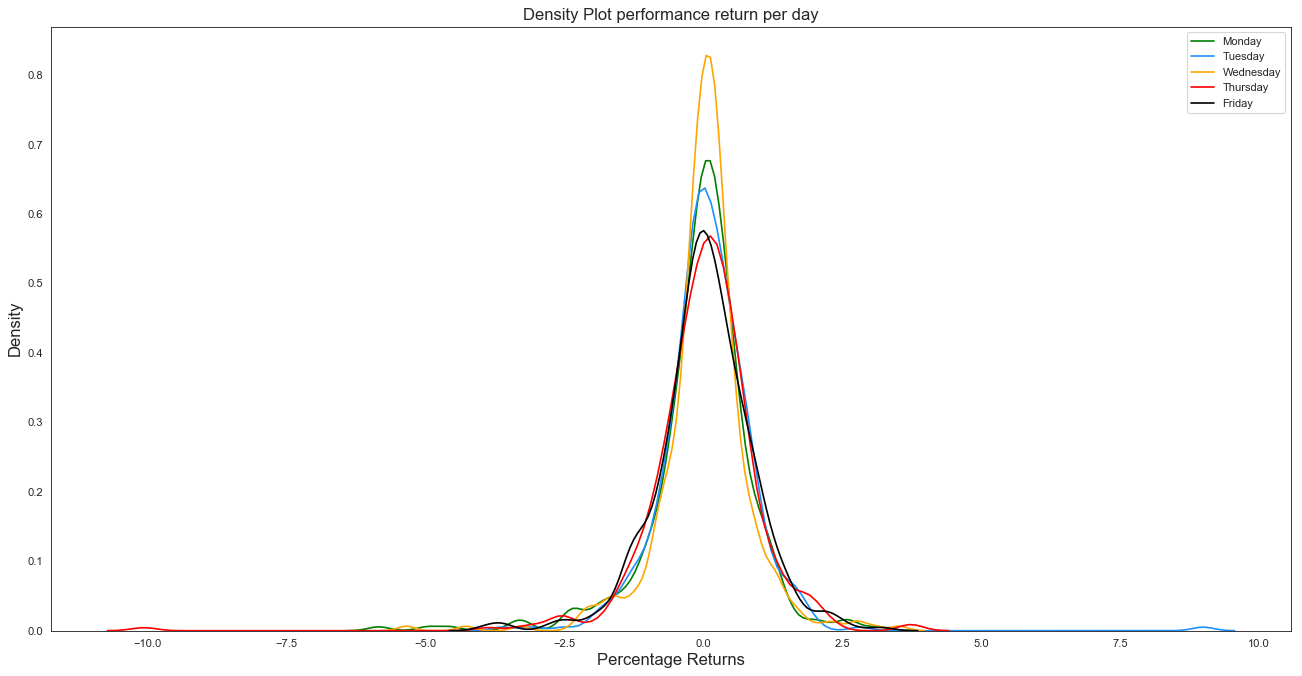

In [5]:
import seaborn as sns
sns.set_style("white")

plt.figure(figsize=(20,10), dpi= 80)
sns.kdeplot(df.loc[df['weekday'] == "Monday", "pct_change"], shade=False, color="g", label="Monday", alpha=1)
sns.kdeplot(df.loc[df['weekday'] == "Tuesday", "pct_change"], shade=False, color="dodgerblue", label="Tuesday", alpha=1)
sns.kdeplot(df.loc[df['weekday'] == "Wednesday", "pct_change"], shade=False, color="orange", label="Wednesday", alpha=1)
sns.kdeplot(df.loc[df['weekday'] == "Thursday", "pct_change"], shade=False, color="red", label="Thursday", alpha=1)
sns.kdeplot(df.loc[df['weekday'] == "Friday", "pct_change"], shade=False, color="black", label="Friday", alpha=1)
plt.xlabel('Percentage Returns', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title('Density Plot performance return per day', fontsize=15)
plt.legend();
plt.show();

## Median per day of week and boxplot

Wednesday is the day with the highest median performance and Friday is the day with the lowest median performance. It is interesting to note that Wednesday is the day with the strongest and most stable returns. Returns are positive for every single Day of week.

The median results shows a significant difference in revenue with Monday and Friday on one side and Tuesday,Wednesday,Thrusday on the other side.

In [6]:
df.groupby('weekday').median()['pct_change']

weekday
Friday       0.050487
Monday       0.057817
Thursday     0.070502
Tuesday      0.073866
Wednesday    0.076455
Name: pct_change, dtype: float64

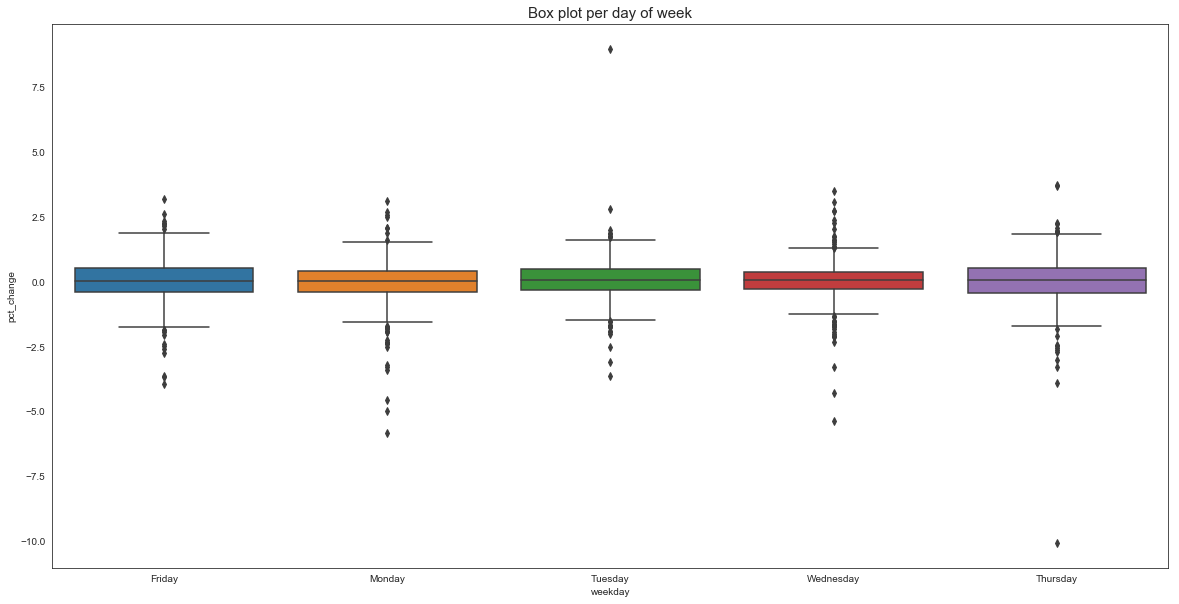

In [7]:
plt.figure(figsize=(20,10))
sns.boxplot(x="weekday", y="pct_change", data=df);
plt.title("Box plot per day of week", fontsize=15);

## kde plot of highest (Wednesday) and lowest (Friday) median

By running a statistical significance test on the distribution of the lowest and highest return day, we can estimate if there is a gain to time the market using day of week.

The p-value comparing the two days is 0.10. This means that there is only 10% chances that the two distribution are similar making the difference statistically significant and not random. The 25th percentile is also much higher for Wednesday, suggesting that there is smaller downside risk on that day


In [8]:
Wednesday = df[df['weekday']=='Wednesday']
Friday = df[df['weekday']=='Friday']
# Kolmogorov test
print('the median daily return for Wednesday is '+str(Wednesday['pct_change'].median().round(5))+'%')
print('the median daily return for Friday is '+str(Friday['pct_change'].median().round(5))+'%')

print('the 25th percentile return for Wednesday is '+str(Wednesday['pct_change'].quantile(.25).round(5))+'%')
print('the 25th percentile return for Friday is '+str(Friday['pct_change'].quantile(.25).round(5))+'%')
# Kolmogorov test
ks_2samp(Wednesday['pct_change'], Friday['pct_change'])

the median daily return for Wednesday is 0.07645%
the median daily return for Friday is 0.05049%
the 25th percentile return for Wednesday is -0.2611%
the 25th percentile return for Friday is -0.39209%


Ks_2sampResult(statistic=0.08413366336633664, pvalue=0.10737077579856569)

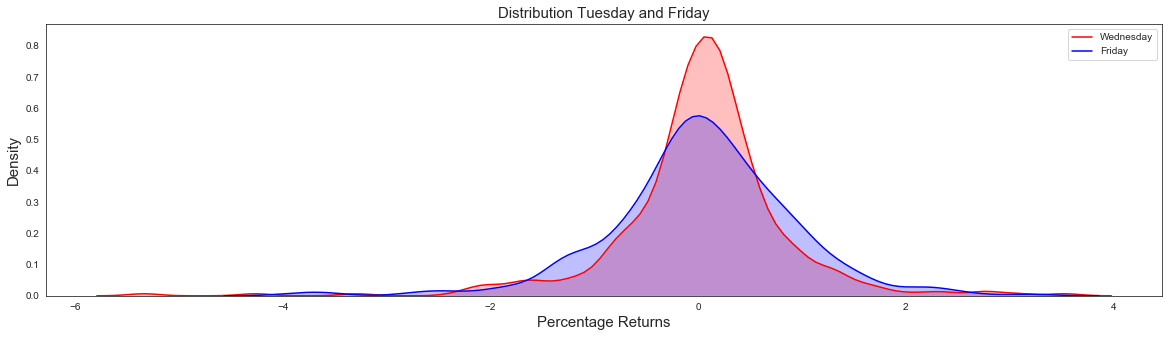

In [9]:
p1 = plt.figure(figsize=(20,5));
p1=sns.kdeplot(Wednesday['pct_change'], shade=True, color="r", label='Wednesday')
p1=sns.kdeplot(Friday['pct_change'], shade=True, color="b", label='Friday')
plt.title('Distribution Tuesday and Friday', fontsize=15)
plt.ylabel('Density', fontsize=15);
plt.xlabel('Percentage Returns', fontsize=15);

## Split days of week in two groups

As the performing and non performing days are in sequence, we can create two groups: group 1 the middle week with Tuesday, Sednesday and Thursdays; and the group 2,the extended weekend with Friday and  Monday

The p-value is however 0.77 making the difference between the two distribution insignificant

In [10]:
# create list of the first 16 days
group1 = [1, 2, 3]
# split df
df1 = df[df['weekday_d'].isin(group1)]
df2 = df[~df['weekday_d'].isin(group1)]

In [11]:
# Kolmogorov test
print('the median daily return for group 1 is '+str(df1['pct_change'].median().round(5))+'%')
print('the median daily return for group 2 is '+str(df2['pct_change'].median().round(5))+'%')

print('the 25th percentile return for group 1 is '+str(df1['pct_change'].quantile(.25).round(5))+'%')
print('the 25th percentile return for group 2 is '+str(df2['pct_change'].quantile(.25).round(5))+'%')


ks_2samp(df1['pct_change'], df2['pct_change'])

the median daily return for group 1 is 0.07221%
the median daily return for group 2 is 0.0559%
the 25th percentile return for group 1 is -0.32156%
the 25th percentile return for group 2 is -0.3766%


Ks_2sampResult(statistic=0.029832854253167253, pvalue=0.7791269284350875)

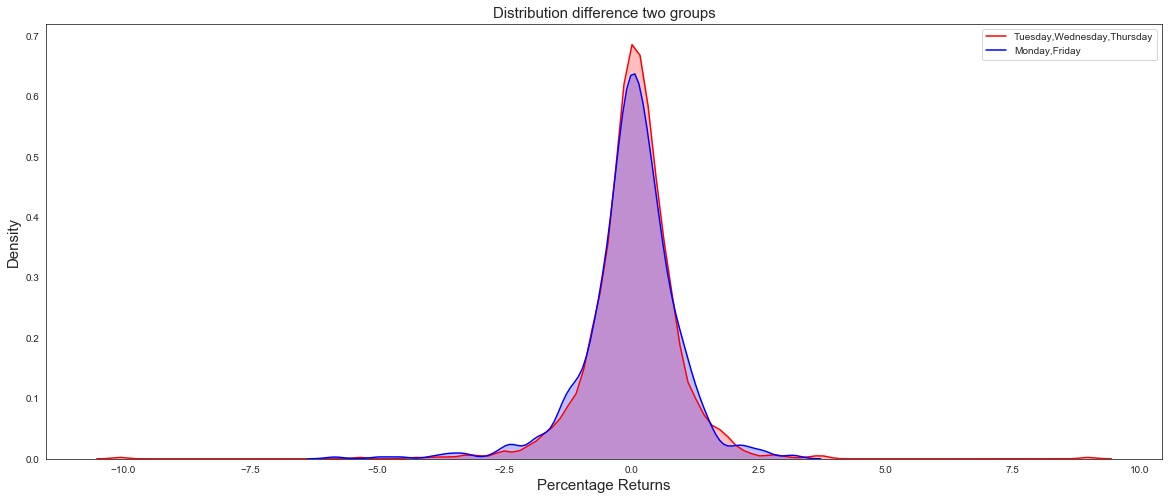

In [12]:
p1 = plt.figure(figsize=(20,8));
p1=sns.kdeplot(df1['pct_change'], shade=True, color="r", label='Tuesday,Wednesday,Thursday')
p1=sns.kdeplot(df2['pct_change'], shade=True, color="b", label='Monday,Friday')
plt.title('Distribution difference two groups', fontsize=15)
plt.ylabel('Density', fontsize=15);
plt.xlabel('Percentage Returns', fontsize=15);

# Day of month analysis

A clear increase in end of month revenue as suggested by some papers on the SP500 is not visible on the Vanguard ETF. We can however see higher returns on the 1st and 16th of the month which could be explained by pay date and automatic payments.

Visually the first 16 days seems to be higher as well as the first part of the month.

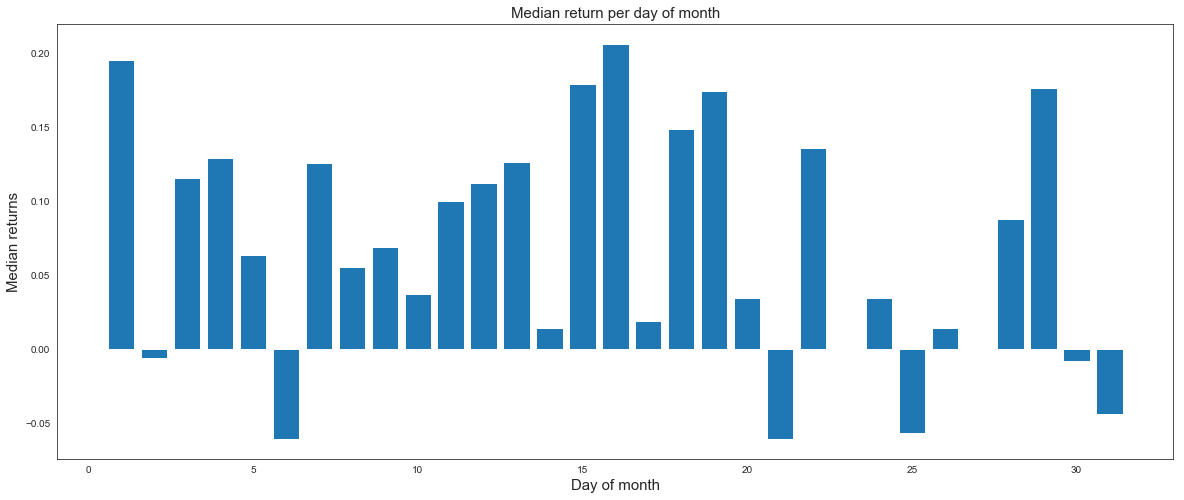

In [13]:
plt.figure(figsize=(20,8))
dom_median = df.groupby('dom').median()['pct_change'].reset_index();
plt.bar(dom_median['dom'], dom_median['pct_change'])
plt.xlabel('Day of month', fontsize=15)
plt.ylabel('Median returns', fontsize=15);
plt.title('Median return per day of month', fontsize=15);

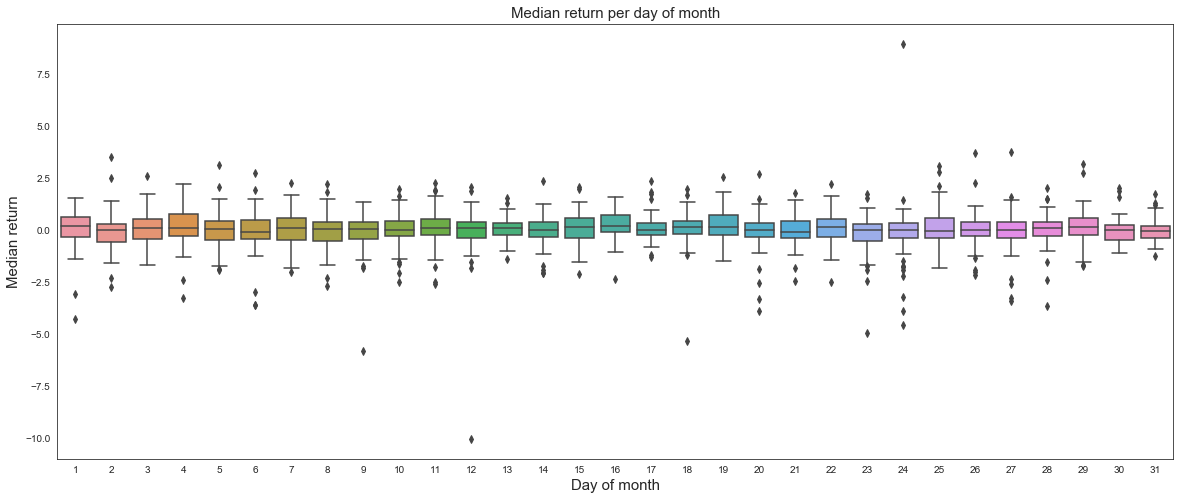

In [14]:
plt.figure(figsize=(20,8));
sns.boxplot(x="dom", y="pct_change", data=df);
plt.xlabel('Day of month', fontsize=15)
plt.ylabel('Median return', fontsize=15);
plt.title('Median return per day of month', fontsize=15);

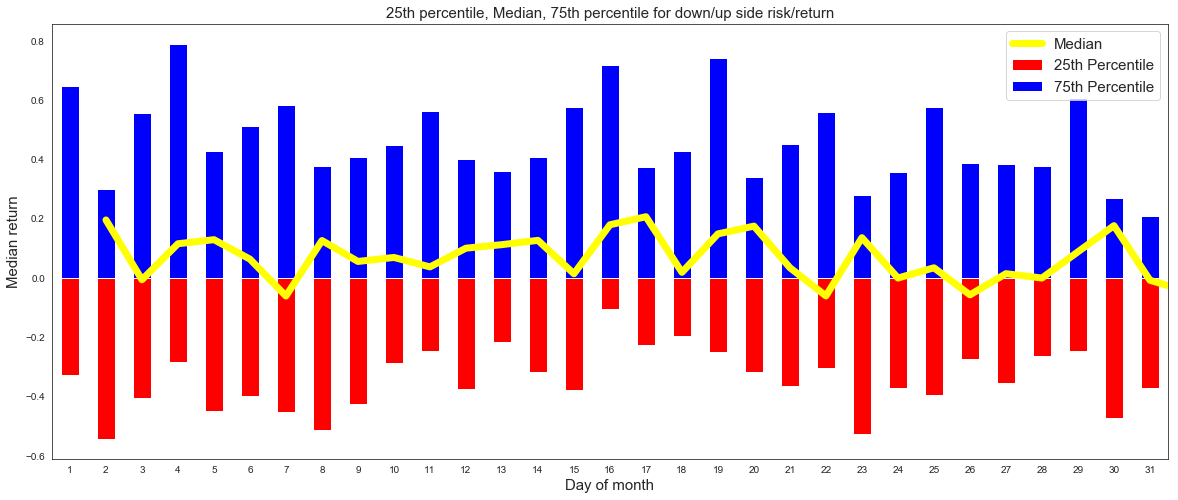

In [15]:
plt.figure(figsize=(20,8));
df.groupby('dom')['pct_change'].quantile(.25).plot.bar(color='red',label='25th Percentile')
df.groupby('dom')['pct_change'].quantile(.75).plot.bar(color='blue',label='75th Percentile');
df.groupby('dom')['pct_change'].quantile(.50).plot(linewidth=7, color='yellow',label='Median');
plt.xlabel('Day of month', fontsize=15)
plt.ylabel('Median return', fontsize=15);
plt.title('25th percentile, Median, 75th percentile for down/up side risk/return', fontsize=15);
plt.legend(fontsize=15);

## split the month in two groups

In [16]:
# create list of the first 16 days
group1 = list(range(1,17)) 
group1
# split df
df1 = df[df['dom'].isin(group1)]
df2 = df[~df['dom'].isin(group1)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

The first part of the month from the 1st to the 16th included is the group 1. The rest of the month is the group two. The median return for group 1 is 0.08% while the median return of group 2 is 0.03%. While the return difference is quite large, the Kolmogorov–Smirnov test has a p-value of .24 which relatively high. We could only statistically conclude that the two distributions are different at only 76% 

In [17]:
# Kolmogorov test
print('the median daily return for group 1 is '+str(df1['pct_change'].median().round(5))+'%')
print('the median daily return for group 2 is '+str(df2['pct_change'].median().round(5))+'%')

print('the 25th percentile return for group 1 is '+str(df1['pct_change'].quantile(.25).round(5))+'%')
print('the 25th percentile return for group 2 is '+str(df2['pct_change'].quantile(.25).round(5))+'%')


ks_2samp(df1['pct_change'], df2['pct_change'])

the median daily return for group 1 is 0.08301%
the median daily return for group 2 is 0.03029%
the 25th percentile return for group 1 is -0.35826%
the 25th percentile return for group 2 is -0.32267%


Ks_2sampResult(statistic=0.045896081352735166, pvalue=0.2379874860487422)

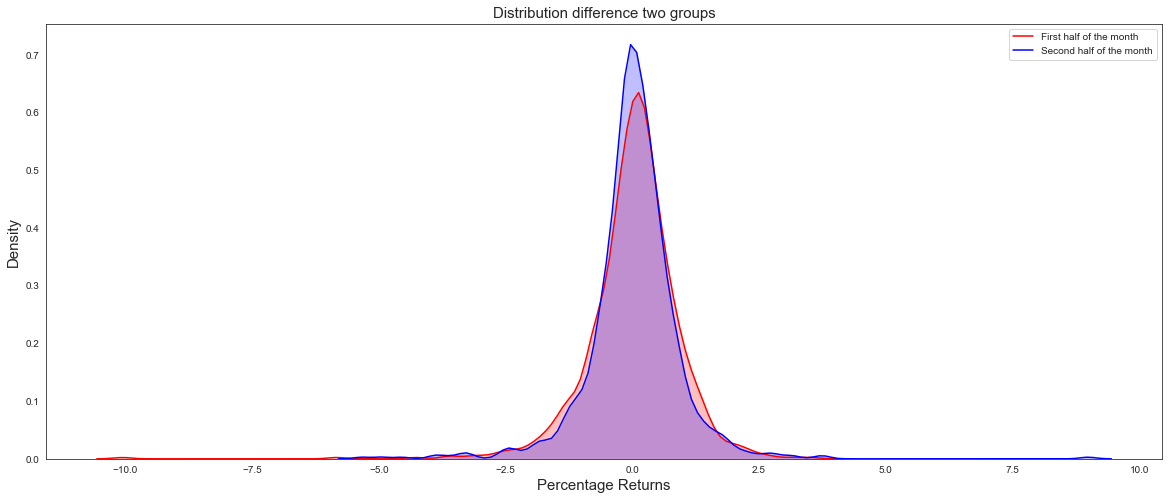

In [18]:
p1 = plt.figure(figsize=(20,8));
p1=sns.kdeplot(df1['pct_change'], shade=True, color="r", label='First half of the month')
p1=sns.kdeplot(df2['pct_change'], shade=True, color="b", label='Second half of the month')
plt.title('Distribution difference two groups', fontsize=15)
plt.ylabel('Density', fontsize=15);
plt.xlabel('Percentage Returns', fontsize=15);